## Part 1 - Install requirements & import libraries

In [ ]:
!pip3 install 'torch'
!pip3 install 'torchvision'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'


In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import vgg16
from torchvision.models import resnet18, resnet50

from PIL import Image
from tqdm import tqdm
import copy
import time

from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt

## Part 2 - Set arguments & transformations (re-run)

In [16]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = 101    # There is am extra Background class that should be removed


LR = 0.01           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1        # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

RANDOM = 42
TRAIN_SIZE = 0.5     # split between training and validation sets

AUGMENTATION_TYPE = 'flip' # Available choice: 'flip', 'brightness', 'both'

#### Train AlexNet from scratch

In [ ]:
NETWORK_TYPE = 'alexnet'
PRETRAINED = False        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
TRANSFER = True
AUGMENTATION = False
FREEZE = 'no_freezing'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'

### Variable adaptation (re-run with Transfer Learning Section, data augmentation & beyond AlexNet)

In [18]:
if NETWORK_TYPE == 'resnet' or NETWORK_TYPE == 'vgg':
  BATCH_SIZE = 16

elif NETWORK_TYPE == 'alexnet':
  BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                       # the batch size, learning rate should change by the same factor to have comparable results

In [19]:
if PRETRAINED:
  mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
else:
  mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

if not AUGMENTATION:
  # Define transforms for training phase
  train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                        transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                    # 224 because torchvision's AlexNet needs a 224x224 input!
                                        transforms.ToTensor(),       # Turn PIL Image to torch.Tensor
                                        transforms.Normalize(mean,std) # Normalizes tensor with mean and standard deviation
                                        ])

  # Define transforms for the evaluation phase
  eval_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
  ])
elif AUGMENTATION and (AUGMENTATION_TYPE == 'flip'):
  train_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.RandomHorizontalFlip(p=1),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
  ])
  eval_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
  ])

elif AUGMENTATION and (AUGMENTATION_TYPE == 'brightness'):
  train_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ColorJitter(brightness=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
  ])
  eval_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
  ])

elif AUGMENTATION and (AUGMENTATION_TYPE == 'both'):
  train_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.RandomHorizontalFlip(p=1),
                                        transforms.ColorJitter(brightness=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
  ])
  eval_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
  ])



## Part 3 - Data Preprocessing & Data Visualization (re-run cells* with transfer learning, data augmentation & beyond AlexNet)

In [ ]:
# Clone github repository with data
if not os.path.isdir('/content/Caltech101/CNN'):
  !git clone https://github.com/peteralhachem/advanced-machine-learning.git
  !mv 'advanced-machine-learning' 'Caltech101'
  os.chdir('Caltech101/CNN/')
else:
  os.chdir('/content/Caltech101/CNN/')

DATA_DIR = os.getcwd()
from caltech_dataset import Caltech

### Split Dataset between training, validation & test samples (re-run with transfer learning & Beyond AlexNet)

In [20]:
# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

# Useful variables to plot distribution number of images per category
class_to_idx = train_dataset.class_to_idx
trainlabels = train_dataset.targets
testlabels = test_dataset.targets
all_labels = trainlabels + testlabels

# split the train_dataset in train and val
sss = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_SIZE, random_state=42)

X = [img[0] for img in train_dataset.samples]
y = [lab[1] for lab in train_dataset.samples]

for train_idx, val_idx in sss.split(X,y) :
  train_indexes = train_idx
  val_indexes = val_idx

subset_val_dataset = Subset(train_dataset, val_indexes)
subset_train_dataset = Subset(train_dataset, train_indexes)


# Check dataset sizes
print('Train Dataset: {}'.format(len(subset_train_dataset)))
print('Validation Dataset: {}'.format(len(subset_val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Validation Dataset: 2892
Test Dataset: 2893


### Plot distribution number of images per category

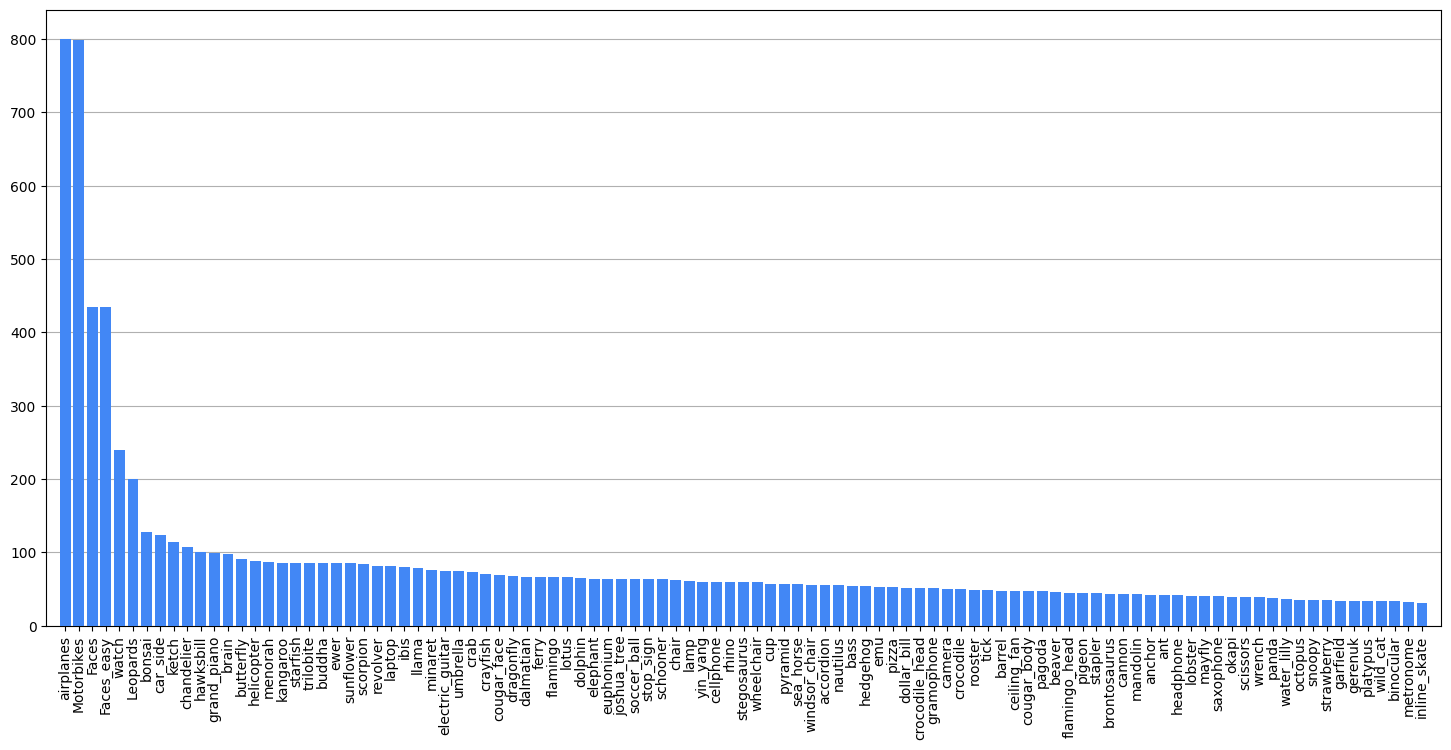

In [ ]:
from collections import Counter

counter = Counter(all_labels)
count_tuples = counter.most_common()
idx_to_class = {v:k for k,v in class_to_idx.items()}
label_arr = [idx_to_class[target] for target,cnt in count_tuples]
count_arr = [cnt for target,cnt in count_tuples]


plt.figure(figsize=(18, 8))
plt.grid(axis='y',zorder=0)
plt.margins(x=0.01)
plt.bar(label_arr, count_arr, color='#4287f5', align='center', zorder=3)
plt.xticks(rotation='vertical')
plt.show()

### Prepare Dataloaders (re-run cell with transfer learning, data augmentation & beyond AlexNet)

In [21]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(subset_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(subset_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### Visualize a batch of images from the training set

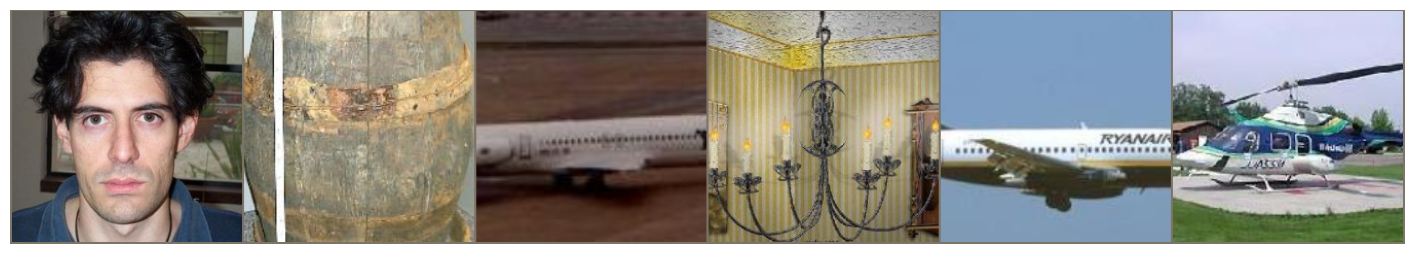

In [ ]:
def imgshow(img, mean, std):
    # Convert mean and std to tensors with the same device as img
    mean = torch.tensor(mean, device=img.device)
    std = torch.tensor(std, device=img.device)

    # Reshape mean and std to have the same number of channels as the image
    mean = mean.view(1, 3, 1, 1)  # Reshape to (1, 3, 1, 1)
    std = std.view(1, 3, 1, 1)    # Reshape to (1, 3, 1, 1)

    # Perform unnormalization
    img = img * std + mean

    npimg = img.cpu().numpy()

    npimg = np.transpose(npimg, (0, 2, 3, 1))

    plt.figure(figsize=(18, 8))
    plt.imshow(npimg[0])
    plt.axis('off')
    plt.show()
    return

x, y = next(iter(DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, drop_last=True)))
out = torchvision.utils.make_grid(x)
imgshow(out, mean, std)

## Part 4 - Network & Testing preparation (re-run)

### Prepare Network (re-run cell with each model change)

In [22]:
if NETWORK_TYPE == 'alexnet':
  if PRETRAINED:
    net = alexnet(weights='IMAGENET1K_V1') # Loading AlexNet model, if pretrained = True, returns a model pre-trained on ImageNet
  else:
    net = alexnet() # If False, returns a model without pre-trained ImageNet weights

  # AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
  # We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                   # The convolutional layer is nn.Conv2d
# EXTRA REQUIREMENTS
elif NETWORK_TYPE == 'vgg':
  if PRETRAINED:
    net = vgg16(weights='IMAGENET1K_V1')
  else:
    net = vgg16()

  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

elif NETWORK_TYPE == 'resnet':
  if TRANSFER:
    net = resnet50(weights='IMAGENET1K_V1') # If True, returns a model pre-trained on ImageNet
    #net = resnet18(pretrained=TRANSFER)
    num_features = net.fc.in_features
    net.fc = nn.Linear(num_features, NUM_CLASSES)
    #NUM_EPOCHS = [10, 10, 10, 10, 10]
  else:
    net = resnet50() # If False, returns a model pre-trained on ImageNet
    #net = resnet18(pretrained=TRANSFER)
    num_features = net.fc.in_features
    net.fc = nn.Linear(num_features, NUM_CLASSES)
    #NUM_EPOCHS = [10, 10, 10, 10, 10]

# print the chosen network
print(net)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Prepare Training (re-run cell with each model change)

In [23]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
if (FREEZE == 'no_freezing'):
  parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
elif (FREEZE == 'conv_layers'):
  parameters_to_optimize = net.classifier.parameters() # In this case we optimize only over the features
elif (FREEZE == 'fc_layers'):
  parameters_to_optimize = net.features.parameters()

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

## Part 5 - Training & Validation Phase

### Train Network

In [24]:
print("Current Hyperparameters: ")
print(f"N_EPOCHS: {NUM_EPOCHS}")
print(f"STEP_SIZE: {scheduler.step_size}")
print(f"Optimizer: \n{optimizer}")

start = time.time()

# By default, everything is loaded to cpu
net = net.to(DEVICE) # bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime

# save best config
best_net = 0
best_epoch = 0
best_val_acc = 0.0

# save accuracy and loss
scratch_train_accuracies = []
scratch_train_losses = []
scratch_val_accuracies = []
scratch_val_losses = []

current_step = 0

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print(f"Starting epoch {epoch+1}/{NUM_EPOCHS}, LR = {scheduler.get_last_lr()}")

  ### ---- TRAINING PHASE ----

  net.train() # Sets module in training mode

  running_corrects_train = 0
  running_loss_train = 0.0

  # Iterate over the training dataset
  for images, labels in train_dataloader:

    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    with torch.set_grad_enabled(True):

      # Forward pass to the network
      outputs_train = net(images)

      _, preds = torch.max(outputs_train, 1)

      # Compute loss based on output and ground truth
      loss = criterion(outputs_train, labels)

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

    current_step += 1

    # store loss and accuracy values
    running_corrects_train += torch.sum(preds == labels.data)
    running_loss_train += loss.item() * images.size(0)

  train_acc = 100 * running_corrects_train / float(len(subset_train_dataset))
  train_loss = running_loss_train / float(len(subset_train_dataset))

  scratch_train_accuracies.append(train_acc)
  scratch_train_losses.append(train_loss) # loss computed as the average on mini-batches
  #train_loss.append(loss.item()) # loss computed only on the last batch

  print(f"Training Accuracy: {train_acc:.4f}%")

  ### ---- END TRAINING PHASE OF AN EPOCH ----

  ### ---- VALIDATION PHASE ----

  net.train(False) # Set Network to evaluation mode

  running_corrects_val = 0
  running_loss_val = 0.0

  for images, labels in val_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # zero the parameter gradients
    optimizer.zero_grad()

    with torch.set_grad_enabled(False):

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs, 1)

      # Calculate Loss
      loss = criterion(outputs.data, labels)

    # Update Corrects and Loss
    running_loss_val += loss.item() * images.size(0)
    running_corrects_val += torch.sum(preds == labels.data)

  # Compute epoch loss and accuracy
  val_loss = running_loss_val/ float(len(subset_val_dataset))
  val_acc = 100 * running_corrects_val / float(len(subset_val_dataset))

  # memorize stats
  scratch_val_losses.append(val_loss)
  scratch_val_accuracies.append(val_acc)

  print(f"Validation Accuracy: {val_acc:.4f}%")

  # Check if the current epoch val accuracy is better than the best found until now
  if (val_acc >= best_val_acc) :
    best_val_acc = val_acc
    best_epoch = epoch
    best_net = copy.deepcopy(net) # deep copy the model

  # Step the scheduler
  scheduler.step()

print(f"\nBest epoch: {best_epoch+1}\n{best_val_acc:.4f} (Validation Accuracy)\n")
print(f"> In {(time.time()-start)/60:.2f} minutes")


Current Hyperparameters: 
N_EPOCHS: 30
STEP_SIZE: 20
Optimizer: 
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 5e-05
)
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.642410755157471
Step 10, Loss 3.9398205280303955
Step 20, Loss 5.071611404418945
Step 30, Loss 1.7374662160873413
Step 40, Loss 3.241725444793701
Step 50, Loss 1.913508653640747
Step 60, Loss 3.2975666522979736
Step 70, Loss 2.3117799758911133
Step 80, Loss 4.113616943359375
Step 90, Loss 1.3363683223724365
Step 100, Loss 2.838266134262085
Step 110, Loss 2.1292831897735596
Step 120, Loss 2.9504239559173584
Step 130, Loss 2.28831148147583
Step 140, Loss 2.7094011306762695
Step 150, Loss 2.987184762954712
Step 160, Loss 2.4567060470581055
Step 170, Loss 2.080378532409668
Training Accuracy: 46.0581%
Validation Accuracy: 63.8313%
Starting epoch 2/30, LR = [0.01]
S

In [25]:
### ---- TESTING PHASE ----

net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

test_accuracies = []
running_corrects = 0

for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects * 100 / float(len(test_dataset))
test_accuracies.append(accuracy)

print(f'\nTest Accuracy: {accuracy:.4f} %')

100%|██████████| 181/181 [00:10<00:00, 17.47it/s]


Test Accuracy: 90.5289 %


#### Plot training accuracy vs validation accuracy

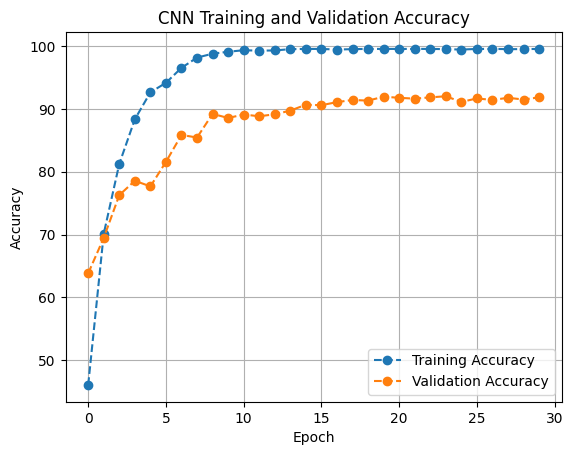

In [26]:
plt.plot( [x.cpu().item() for x in scratch_train_accuracies] , label='Training Accuracy', linestyle='dashed', marker='o')
plt.plot( [x.cpu().item() for x in scratch_val_accuracies], label='Validation Accuracy', linestyle='dashed', marker='o')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## Part 6 - Transfer Learning

#### Pretrained AlexNet

In [ ]:
NETWORK_TYPE = 'alexnet'
PRETRAINED = True        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
TRANSFER = True
AUGMENTATION = False
FREEZE = 'no_freezing'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'

#### Freeze the fully connected layer

In [ ]:
NETWORK_TYPE = 'alexnet'
PRETRAINED = True        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
TRANSFER = True
AUGMENTATION = False
FREEZE = 'fc_layers'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'

#### Freeze the convolutional layer

In [ ]:
NETWORK_TYPE = 'alexnet'
PRETRAINED = True        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
TRANSFER = True
AUGMENTATION = False
FREEZE = 'conv_layers'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'

## Part 7 - Data Augmentation

### Perform Horizontal Flip

In [ ]:
NETWORK_TYPE = 'alexnet'
PRETRAINED = True        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
TRANSFER = True
AUGMENTATION = True
AUGMENTATION_TYPE = 'flip'   # Available choice: 'flip', 'brightness', 'both'
FREEZE = 'no_freezing'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'

### Perform Brightness

In [ ]:
NETWORK_TYPE = 'alexnet'
PRETRAINED = True        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
TRANSFER = True
AUGMENTATION = True
AUGMENTATION_TYPE = 'brightness'   # Available choice: 'flip', 'brightness', 'both'
FREEZE = 'no_freezing'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'

### Combine both Horizontal flip & brightness

In [ ]:
NETWORK_TYPE = 'alexnet'
PRETRAINED = True        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
TRANSFER = True
AUGMENTATION = True
AUGMENTATION_TYPE = 'both'   # Available choice: 'flip', 'brightness', 'both'
FREEZE = 'no_freezing'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'

## Part 8 - Beyond AlexNet




### VGG (from scratch)

In [ ]:
NETWORK_TYPE = 'vgg'
PRETRAINED = False        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
AUGMENTATION = False
FREEZE = 'no_freezing'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'

### VGG (Pretrained)

In [ ]:
NETWORK_TYPE = 'vgg'
PRETRAINED = True        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
AUGMENTATION = False
FREEZE = 'no_freezing'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'

### ResNet (without transfer learning)

In [5]:
NETWORK_TYPE = 'resnet'
PRETRAINED = True        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
TRANSFER = False
AUGMENTATION = False
FREEZE = 'no_freezing'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'

### ResNet (with transfer learning)

In [17]:
NETWORK_TYPE = 'resnet'
PRETRAINED = True        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
TRANSFER = True
AUGMENTATION = False
FREEZE = 'no_freezing'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'